In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('../../py-utils/src/')
from viz import show_images

sys.path.append('../../plume_dynamic_analyzer/src/')
from analyzer.plume_utils import remove_all_0_plume
from analyzer.PlumeDataset import plume_dataset

In [2]:
df_condition = pd.read_excel('../../data/Sample log.xlsx', sheet_name='SRO')
# df_condition = df_condition.loc[[27, 34, 35, 36, 37, 38, 39, 40], ['Growth', 'Pressure (mTorr)', 'Temperature (C)', 'Fluence (J/cm2)', 'Repetation rate (Hz)']]
df_condition = df_condition.loc[[36, 37, 38, 39, 40], ['Growth', 'Pressure (mTorr)', 'Temperature (C)', 'Fluence (J/cm2)', 'Repetation rate (Hz)']]
df_condition.replace('700 (heater O)', 700, inplace=True)
df_condition.replace('650 (heater O)', 650, inplace=True)
df_condition.replace('700 (heater N)', 700, inplace=True)
df_condition['Growth'] = df_condition['Growth'].str.replace(r'LYW_YCG', 'YG', regex=True)
df_condition.sample(5)

,Growth,Pressure (mTorr),Temperature (C),Fluence (J/cm2),Repetation rate (Hz)
37,YG066,100.0,700,1.6,5.0
39,YG068,100.0,700,1.6,5.0
40,YG069,100.0,700,1.6,6.6
36,YG065,100.0,700,1.6,5.0
38,YG067,100.0,700,1.6,5.0


### load frame level metrics

In [6]:
df_frame_metrics = []
for key in df_condition['Growth'].unique():
    file = glob.glob(f'../../large_files/SRO_plume_metrics/{key}*metrics.csv')[0]
    # print(file)
    df = pd.read_csv(file, index_col=0)
    df['Threshold'].astype(str)
    df = df[df['Threshold']=='200']
    df = remove_all_0_plume(df.reset_index(), metric='Area', viz=False)
    df_frame_metrics.append(df)
    
df_frame_metrics = pd.concat(df_frame_metrics, ignore_index=True)
df_frame_metrics['time_index'] = df_frame_metrics['time_index'] * 500e-3 # convert ns to ms
df_frame_metrics.rename(columns={'time_index': 'Time (µs)'}, inplace=True)
df_frame_metrics.rename(columns={'plume_index': 'Plume Index'}, inplace=True)

# df_frame_metrics_target = df_frame_metrics[df_frame_metrics['Growth'].isin(['YG065', 'YG066', 'YG067', 'YG068', 'YG069'])]
df_frame_metrics_target = df_frame_metrics[df_frame_metrics['Growth'].isin(['YG066'])]
df_sample = df_frame_metrics_target[(df_frame_metrics_target['Time (µs)'] >= 0.5) & (df_frame_metrics_target['Time (µs)'] < 7)] 
df_sample.sample(5)

,Plume Index,Time (µs),Distance,Velocity,Area,Threshold,Growth
88838,313,3.0,185,32000000.0,14373.0,200,YG066
89224,316,4.0,196,12000000.0,10376.0,200,YG066
53387,35,5.5,197,0.0,862.0,200,YG066
49548,5,6.0,212,0.0,263.0,200,YG066
63116,111,6.0,202,0.0,11.0,200,YG066


### load plume

In [12]:
file = 'D:/pld_plumes/SRO_STO_Drexel/YG066_YichenGuo_09112024.h5'
plume_ds = plume_dataset(file_path=file, group_name='PLD_Plumes')
keys = plume_ds.dataset_names()
print(keys)
plumes = plume_ds.load_plumes('1-SrRuO3')
print(plumes.shape)

['1-SrRuO3', '1-SrRuO3_Pre']
(385, 128, 250, 400)


### heatmap

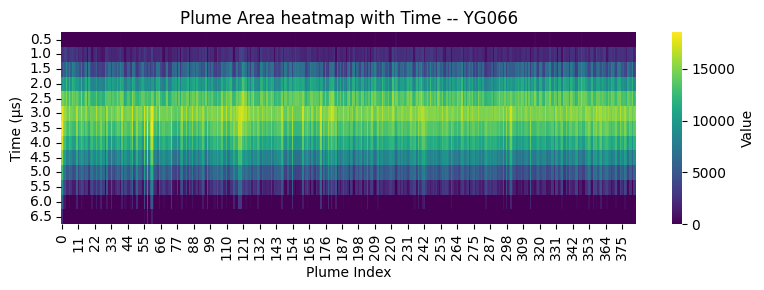

In [13]:
# df_sample = df_sample[(df_sample['Plume Index'] >= 50) & (df_sample['Plume Index'] < 150)] 

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
df_pivot = df_sample.pivot(index="Time (µs)", columns="Plume Index", values="Area")
sns.heatmap(df_pivot, cmap='viridis', cbar_kws={'label': 'Value'}, ax=ax)
ax.set_xlabel("Plume Index")
ax.set_ylabel("Time (µs)")
plt.title("Plume Area heatmap with Time -- YG066")
plt.tight_layout()
plt.show()

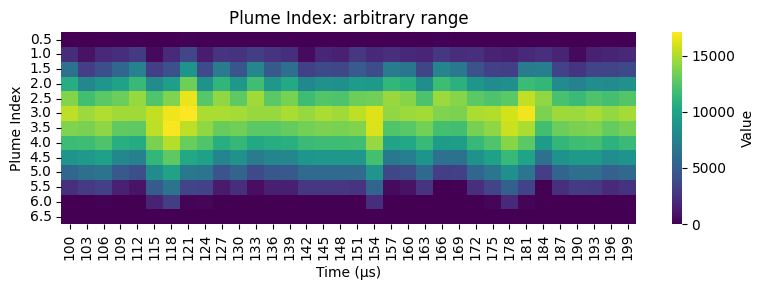

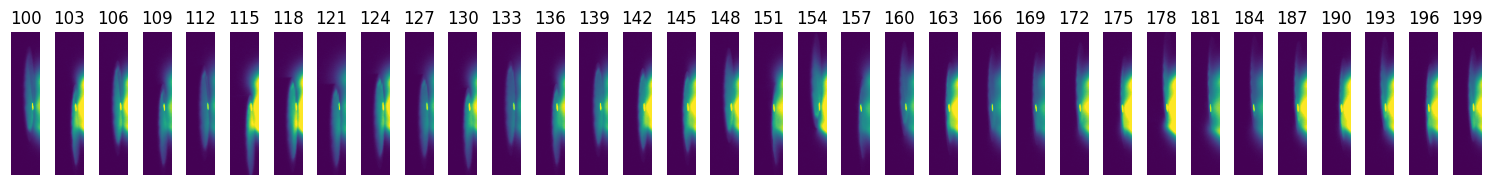

In [21]:
arb_list = range(100, 200, 3)

df_filtered = df_sample[df_sample['Plume Index'].isin(arb_list)]
                        
df_pivot = df_filtered.pivot(index="Time (µs)", columns="Plume Index", values="Area")

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
sns.heatmap(df_pivot, cmap='viridis', cbar_kws={'label': 'Value'}, ax=ax)
ax.set_xlabel("Time (µs)")
ax.set_ylabel("Plume Index")
ax.set_title(f"Plume Index: arbitrary range")
plt.tight_layout()
plt.show()

plume_sample = plumes[arb_list, 6, :, :50]
fig, axes = plt.subplots(1, len(plume_sample), figsize=(15, 3))
show_images(plume_sample, img_per_row=len(plume_sample), img_height=3, axes=axes, labels=arb_list)
    
# plt.suptitle("Plume Area heatmap with Time -- YG065")

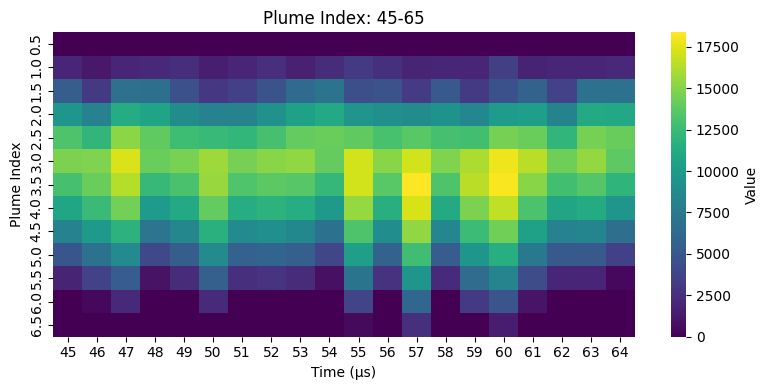

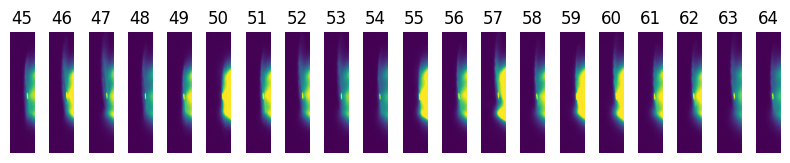

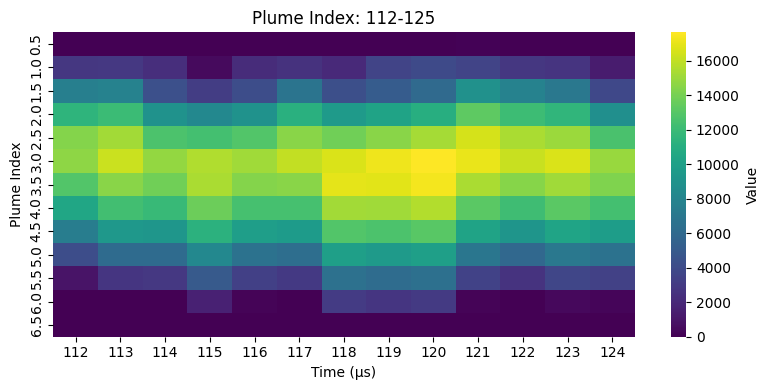

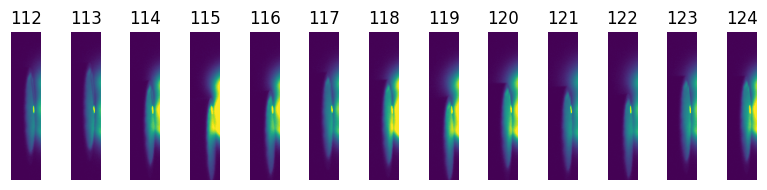

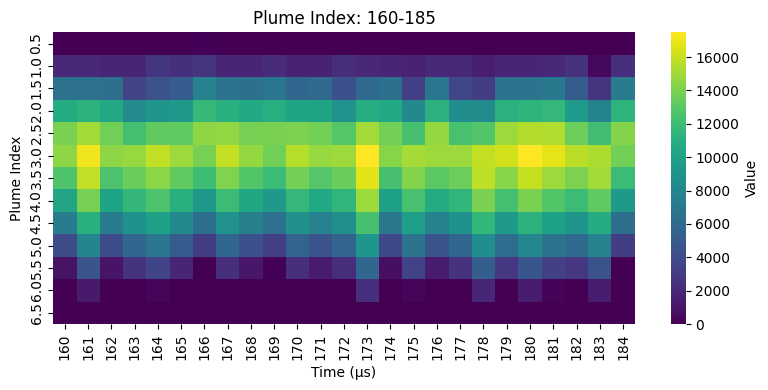

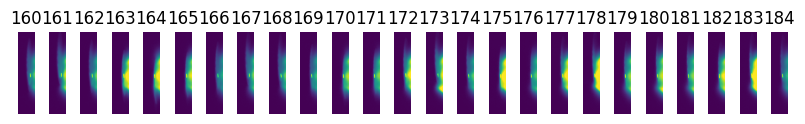

In [25]:
ranges = [(45, 65), (112, 125), (160, 185)]

for r in ranges:
    df_filtered = df_sample[(df_sample['Plume Index'] >= r[0]) & (df_sample['Plume Index'] < r[1])] 
    df_pivot = df_filtered.pivot(index="Time (µs)", columns="Plume Index", values="Area")
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    sns.heatmap(df_pivot, cmap='viridis', cbar_kws={'label': 'Value'}, ax=ax)
    ax.set_xlabel("Time (µs)")
    ax.set_ylabel("Plume Index")
    ax.set_title(f"Plume Index: {r[0]}-{r[1]}")
    plt.tight_layout()
    plt.show()
    
    plume_sample = plumes[r[0]:r[1], 6, :, :50]
    fig, axes = plt.subplots(1, len(plume_sample), figsize=(8, 2))
    show_images(plume_sample, img_per_row=len(plume_sample), img_height=2, axes=axes, labels=list(range(r[0], r[1])))

    
# plt.suptitle("Plume Area heatmap with Time -- YG065")

#### parse the plume for specific frame

['1-SrRuO3', '1-SrRuO3_Pre']
(387, 128, 250, 400)


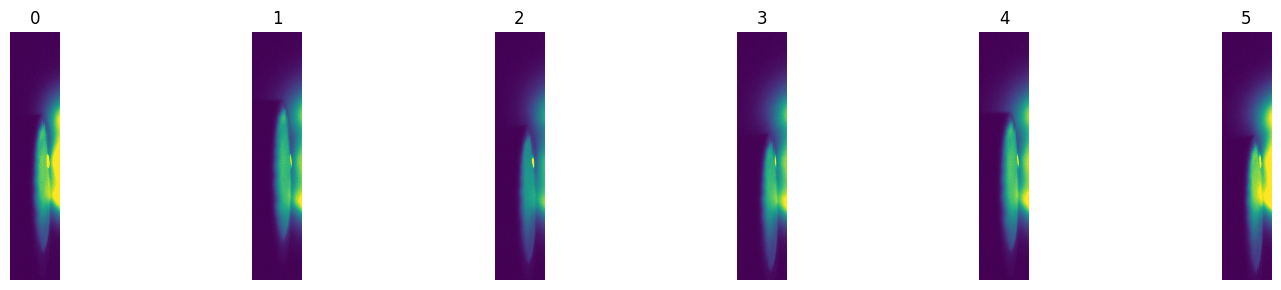

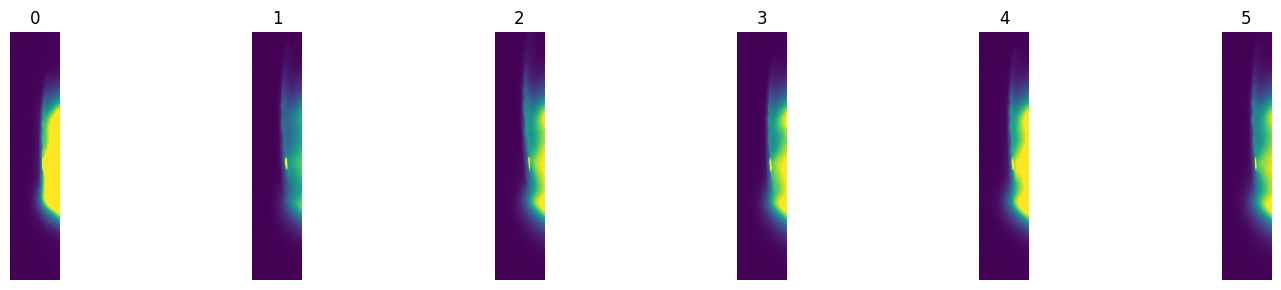

In [19]:
plume_sample = plumes[60:66, 6, :, :50]
show_images(plume_sample, img_per_row=6, img_height=2)

plume_sample = plumes[120:126, 6, :, :50]
show_images(plume_sample, img_per_row=6, img_height=2)

plume_sample = plumes[60:66, 6, :, :50]
show_images(plume_sample, img_per_row=6, img_height=2)

plume_sample = plumes[120:126, 6, :, :50]
show_images(plume_sample, img_per_row=6, img_height=2)

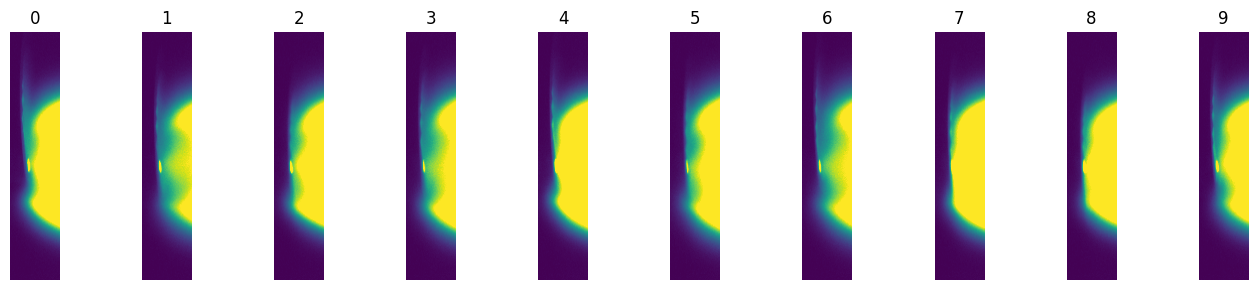

In [24]:
plume_sample = plumes[46:56, 6, :, :50]
show_images(plume_sample, img_per_row=12, img_height=3)

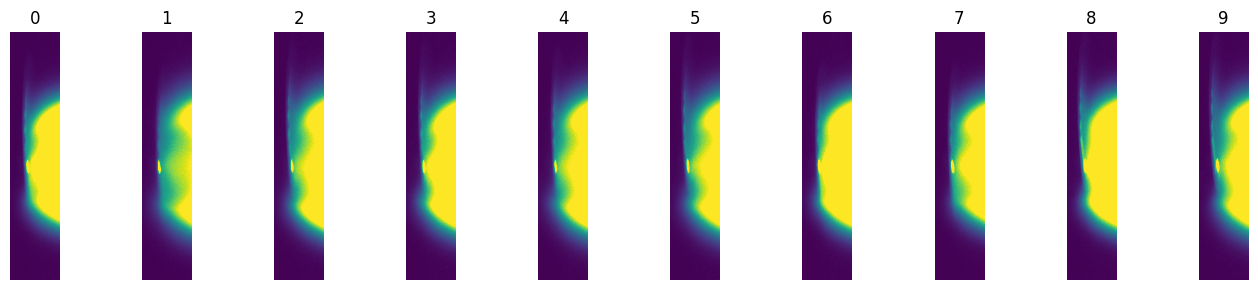

In [27]:
plume_sample = plumes[157:167, 6, :, :50]
show_images(plume_sample, img_per_row=12, img_height=3)

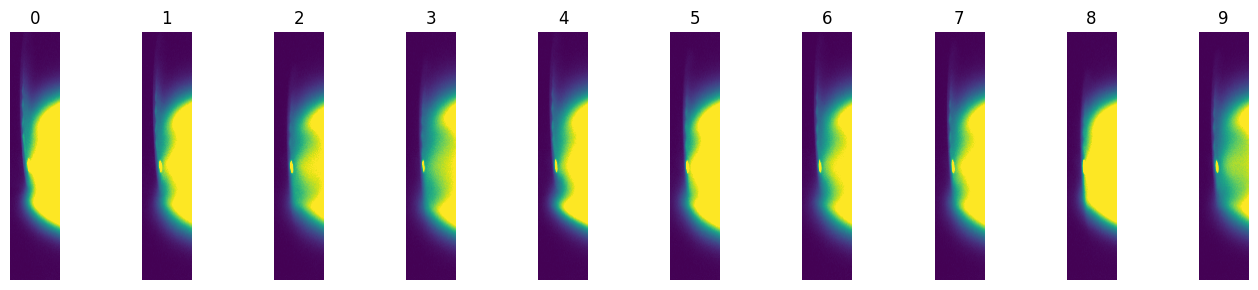

In [30]:
plume_sample = plumes[265:275, 6, :, :50]
show_images(plume_sample, img_per_row=12, img_height=3)